# MICOM analysis

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

import pandas as pd

import micom
from micom import Community, load_pickle

from biofoundry.data.amils2023 import Amils2023DataLoader
from biofoundry.micom import MICOMPreloader, plot_abundances_depth
from biofoundry.utils import save_fig

In [3]:
def save_sol(
    sol: micom.solution.CommunitySolution,
    path: str
) -> None:
    sol_df = sol.members.copy()
    sol_df["community_growth_rate"] = sol.growth_rate
    sol_df["status"] = sol.status

    sol_df.to_csv(path)

In [4]:
# Load config

with open("../biofoundry/config.yml") as config_file:
    config = yaml.safe_load(config_file)

In [5]:
output_dir = os.path.join(
    config["paths"]["micom"],
    "amils2023"
)

data_loader = Amils2023DataLoader()
preloader = MICOMPreloader(config)

In [6]:
abundances_df = data_loader.get_abundances()
abundances_df

/Users/filiberto/miniconda3/envs/biofoundry-micom/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/filiberto/git/astrobio/tfm/mars-biofoundry/notebooks/../biofoundry/data/amils2023/data_loader.py:397: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()
/Users/filiberto/git/astrobio/tfm/mars-biofoundry/notebooks/../biofoundry/data/amils2023/data_loader.py:400: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


,genus,sample_id,abundance
0,Acidiphilium,BH10-103-Illumina,0.0
1,Aciditerrimonas,BH10-103-Illumina,0.0
2,Acidovorax,BH10-103-Illumina,0.0
3,Acinetobacter,BH10-103-Illumina,0.0
4,Actinobacillus,BH10-103-Illumina,0.0
...,...,...,...
1031,Spirosoma,BH10-496-Roche,0.0
1032,Truepera,BH10-496-Roche,0.0
1033,WPS-1_genera_incertae_sedis,BH10-496-Roche,0.0
1034,Xylanimicrobium,BH10-496-Roche,0.0


In [7]:
metadata_df = pd.read_csv(
    os.path.join(
        config["paths"]["genomes"],
        "genomes-metadata.csv"
    )
)

taxonomy_df = preloader.get_taxonomy(metadata_df)
taxonomy_df

,id,genus,species,reactions,metabolites,file
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json


### Combining taxonomy and abundances

In [8]:
# TODO: divide counts for Tessaracoccus and Rhizobium!!!
taxonomy_abundances = pd.merge(
    left=taxonomy_df,
    right=abundances_df,
    on="genus",
    how="left"
)

# Combine ID column with sample ID to avoid errors in MICOM due to ID duplicates
taxonomy_abundances["id"] = \
    taxonomy_abundances["id"] + "_" + taxonomy_abundances["sample_id"]

print(
    "[WARNING] Species for which there are no abundance data:\n",
    taxonomy_abundances[taxonomy_abundances["id"].isnull()]["species"].values
)

# Save to file
taxonomy_abundances.to_csv(
    os.path.join(
        output_dir,
        "taxonomy.csv"
    ),
    header=True,
    index=False,
    sep=","
)

[WARNING] Species for which there are no abundance data:
 ['Brevundimonas sp. T2.26MG-97' 'Desulfosporosinus meridiei DEEP'
 'Rhodoplanes sp. T2.26MG-98' 'Shewanella sp. T2.3D-1.1']


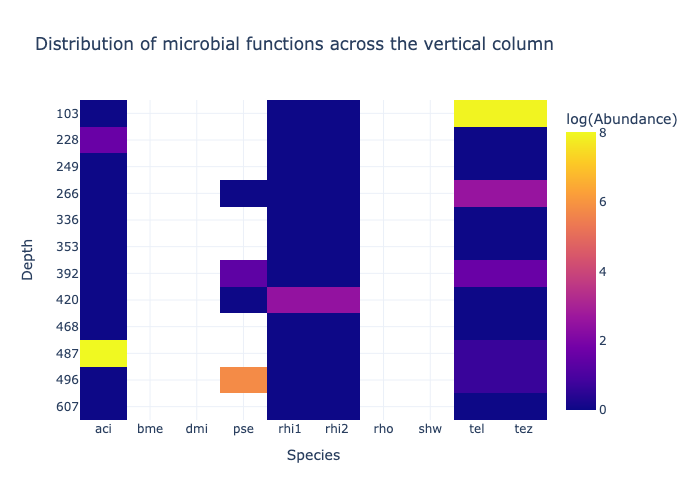

In [16]:
fig = plot_abundances_depth(
    taxonomy_df=taxonomy_abundances,
    config=config
)
fig.show("png")

save_fig(
    fig=fig,
    filename="abundances-depth.jpg",
    config=config
)

In [10]:
%%script false --no-raise-error

# Build community
com = Community(taxonomy_abundances)

# Save community
com.to_pickle(
    os.path.join(
        output_dir,
        "community.pickle"
    )
)

# Get tradeoffs
sol = com.cooperative_tradeoff()

# Experiments

### 1. Same abundance among species

1.1. Objective: community growth

1.2. Objective: production of metabolite of interest

1.3. Objective: community growth + production of metabolite of interest

1.4. Objective: community growth + production of metabolite of interest + anaerobic conditions

In [11]:
# Create new dataframe with just one sample and equal abundances
taxonomy_abundances_equal = taxonomy_abundances.copy()

# Format for dropping duplicates
taxonomy_abundances_equal["id"] = taxonomy_abundances_equal["Code"].copy()
taxonomy_abundances_equal["sample_id"] = "sample_id"
taxonomy_abundances_equal["abundance"] = 1.0
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop(["Code", "Depth", "log_abundance"], axis=1)

# Finally, drop duplicates
taxonomy_abundances_equal = taxonomy_abundances_equal\
    .drop_duplicates()\
    .reset_index(drop=True)

taxonomy_abundances_equal

,id,genus,species,reactions,metabolites,file,sample_id,abundance
0,aci,Acidovorax,Acidovorax BoFeN1,1246,1199,../data/gem/aci_formatted.json,sample_id,1.0
1,bme,Brevundimonas,Brevundimonas sp. T2.26MG-97,431,460,../data/gem/bme_formatted.json,sample_id,1.0
2,dmi,Desulfosporosinus,Desulfosporosinus meridiei DEEP,1157,1104,../data/gem/dmi_formatted.json,sample_id,1.0
3,pse,Pseudomonas,Pseudomonas sp. T2.31D-1,1461,1295,../data/gem/pse_formatted.json,sample_id,1.0
4,rhi1,Rhizobium,Rhizobium sp. T2.30D-1.1,712,797,../data/gem/rhi1_formatted.json,sample_id,1.0
5,rhi2,Rhizobium,Rhizobium sp. T2.26MG-112.2,683,773,../data/gem/rhi2_formatted.json,sample_id,1.0
6,rho,Rhodoplanes,Rhodoplanes sp. T2.26MG-98,442,490,../data/gem/rho_formatted.json,sample_id,1.0
7,shw,Shewanella,Shewanella sp. T2.3D-1.1,1324,1193,../data/gem/shw_formatted.json,sample_id,1.0
8,tel,Tessaracoccus,Tessaracoccus lapidicaptus IPBSL-7,1199,1111,../data/gem/tel_formatted.json,sample_id,1.0
9,tez,Tessaracoccus,Tessaracoccus sp. T2.5-30,1197,1114,../data/gem/tez_formatted.json,sample_id,1.0


In [12]:
# Build community
com = Community(taxonomy_abundances_equal)

# Save community
equal_abundances_path = os.path.join(
    output_dir,
    "equal_abundances/"
    "community_abundances_equal.pickle"
)
com.to_pickle(equal_abundances_path)

Output()

#### 1.1. Objective: community growth

In [13]:
%%script false --no-raise-error

# Load community
com = load_pickle(equal_abundances_path)

# Get tradeoffs
sol = com.cooperative_tradeoff(fraction=0.5)
sol

In [14]:
%%script false --no-raise-error

save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "growth_only.csv"
    )
)

#### 1.2. Objective: Production of metabolite of interest

In [15]:
# Get 3-hydroxybutyrate InChI (PubChem)
source_inchikey = "WHBMMWSBFZVSSR-UHFFFAOYSA-M"

modelseed_cpd = pd.read_table(
    os.path.join(
        config["paths"]["modelseed"],
        "compounds.tsv"
    ),
    dtype=object # Avoid warnings
)

# Not found by InChIKey
modelseed_cpd[modelseed_cpd["inchikey"] == source_inchikey]

,id,abbreviation,name,formula,mass,source,inchikey,charge,is_core,is_obsolete,...,is_cofactor,deltag,deltagerr,pka,pkb,abstract_compound,comprised_of,aliases,smiles,notes


In [16]:
source_matches = modelseed_cpd["aliases"].dropna(axis=0)\
    .str.findall("3-hydroxybutyrate")\
    .apply(",".join)

source_matches = source_matches[
    source_matches != ""
]

modelseed_cpd.iloc[source_matches.index]

,id,abbreviation,name,formula,mass,source,inchikey,charge,is_core,is_obsolete,...,is_cofactor,deltag,deltagerr,pka,pkb,abstract_compound,comprised_of,aliases,smiles,notes
782,cpd00797,bhb,(R)-3-Hydroxybutanoate,C4H7O3,103.0,Primary Database,WHBMMWSBFZVSSR-GSVOUGTGSA-M,-1,1,0,...,0,-55.56,0.53,1:5:4.41;1:7:15.70,1:7:-2.62,NaN,NaN,Name: (R)-3-Hydroxybutanoate; (R)-3-Hydroxybut...,C[C@@H](O)CC(=O)[O-],GC|EQ|EQU


In [17]:
# Get ModelSEED compound ID and abbreviation to retrieve its reactions in the 
# MICOM community
source_modelseed_id = modelseed_cpd.iloc[source_matches.index]\
    [["id", "abbreviation"]]

source_modelseed_id = \
    source_modelseed_id["id"] + "=" + source_modelseed_id["abbreviation"]

source_modelseed_id = source_modelseed_id.values[0]

# Get all possible combinations for the metabolites:
# ModelSEED ID + abbreviation + all compartments + all organisms
source_micom_ids = [
    f"{source_modelseed_id}_{compartment}"
    for compartment in com.compartments.keys()
]
source_micom_ids

['cpd00797=bhb_c__aci',
 'cpd00797=bhb_e__aci',
 'cpd00797=bhb_m',
 'cpd00797=bhb_c__bme',
 'cpd00797=bhb_e__bme',
 'cpd00797=bhb_c__dmi',
 'cpd00797=bhb_e__dmi',
 'cpd00797=bhb_c__pse',
 'cpd00797=bhb_e__pse',
 'cpd00797=bhb_c__rhi1',
 'cpd00797=bhb_e__rhi1',
 'cpd00797=bhb_c__rhi2',
 'cpd00797=bhb_e__rhi2',
 'cpd00797=bhb_c__rho',
 'cpd00797=bhb_e__rho',
 'cpd00797=bhb_c__shw',
 'cpd00797=bhb_e__shw',
 'cpd00797=bhb_c__tel',
 'cpd00797=bhb_e__tel',
 'cpd00797=bhb_c__tez',
 'cpd00797=bhb_e__tez']

In [18]:
source_reactions = []

for source_id in source_micom_ids:
    try:
        source_reactions += list(
            com.metabolites.get_by_id(source_id).reactions
        )
    except KeyError:
        print(f"[ERROR] ID not found! {source_id}")

# Remove potential duplicates
source_reactions = list(set(source_reactions))
source_reactions

[ERROR] ID not found! cpd00797=bhb_e__aci
[ERROR] ID not found! cpd00797=bhb_c__bme
[ERROR] ID not found! cpd00797=bhb_e__bme
[ERROR] ID not found! cpd00797=bhb_c__dmi
[ERROR] ID not found! cpd00797=bhb_e__dmi
[ERROR] ID not found! cpd00797=bhb_c__rhi1
[ERROR] ID not found! cpd00797=bhb_e__rhi1
[ERROR] ID not found! cpd00797=bhb_c__rhi2
[ERROR] ID not found! cpd00797=bhb_e__rhi2
[ERROR] ID not found! cpd00797=bhb_c__rho
[ERROR] ID not found! cpd00797=bhb_e__rho
[ERROR] ID not found! cpd00797=bhb_c__shw
[ERROR] ID not found! cpd00797=bhb_e__shw
[ERROR] ID not found! cpd00797=bhb_e__tel
[ERROR] ID not found! cpd00797=bhb_e__tez


[<Reaction EX_cpd00797=bhb_m at 0x17d8ca230>,
 <Reaction rxn00038_c__aci at 0x17703e230>,
 <Reaction rxn00992_c__aci at 0x17d017e50>,
 <Reaction rxn00992_c__tez at 0x29aeda230>,
 <Reaction rxn12405_c__pse at 0x17e90b2b0>,
 <Reaction rxn00992_c__tel at 0x29a34bd30>,
 <Reaction EX_cpd00797=bhb_e__pse at 0x17efd05b0>,
 <Reaction rxn00992_c__pse at 0x17ec7e9b0>]

In [19]:
# Change upper bound for allowing production
# See: https://cobrapy-cdiener.readthedocs.io/en/latest/simulating.html#Changing-the-Objectives
# for reaction in source_reactions:
#     reaction.upper_bound = 5000.

#     print(reaction.id, reaction.upper_bound)

In [20]:
# Load community
com = load_pickle(equal_abundances_path)

# Set as objective all reactions in which the target is found
com.objective = source_reactions

print("Objective:", com.objective.expression)

# Get tradeoffs
sol = com.cooperative_tradeoff(
    fraction=0.1,
    fluxes=True,
    pfba=True
)
sol

Objective: 1.0*EX_cpd00797=bhb_e__pse - 1.0*EX_cpd00797=bhb_e__pse_reverse_cbc5d + 1.0*EX_cpd00797=bhb_m - 1.0*EX_cpd00797=bhb_m_reverse_6a492 + 1.0*rxn00038_c__aci - 1.0*rxn00038_c__aci_reverse_580dd + 1.0*rxn00992_c__aci - 1.0*rxn00992_c__aci_reverse_8442a + 1.0*rxn00992_c__pse - 1.0*rxn00992_c__pse_reverse_7a810 + 1.0*rxn00992_c__tel - 1.0*rxn00992_c__tel_reverse_c4952 + 1.0*rxn00992_c__tez - 1.0*rxn00992_c__tez_reverse_50d69 + 1.0*rxn12405_c__pse - 1.0*rxn12405_c__pse_reverse_8921e


,abundance,growth_rate,reactions,metabolites
compartments,,,,
aci,0.1,3.443934,1246,1199
bme,0.1,2.247572,431,460
dmi,0.1,3.434035,1157,1104
medium,NaN,NaN,194,194
pse,0.1,3.457040,1461,1295
...,...,...,...,...
rhi2,0.1,2.223450,683,773
rho,0.1,2.309335,442,490
shw,0.1,3.435740,1324,1193


In [21]:
source_fluxes = [
    reaction.id.split("__")[0]
    for reaction in source_reactions
]

sol.fluxes[source_fluxes]

reaction,EX_cpd00797=bhb_m,rxn00038_c,rxn00992_c,rxn00992_c,rxn12405_c,rxn00992_c,EX_cpd00797=bhb_e,rxn00992_c
compartment,,,,,,,,
aci,NaN,5.034239e-07,1.255809e-06,1.255809e-06,NaN,1.255809e-06,NaN,1.255809e-06
bme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium,-0.000041,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pse,NaN,NaN,4.144804e-04,4.144804e-04,0.000414,4.144804e-04,-0.000414,4.144804e-04
rhi1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rhi2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
save_sol(
    sol=sol,
    path=os.path.join(
        output_dir,
        "equal_abundances/"
        "production_only.csv"
    )
)

#### 1.3. Objective: community growth + production of metabolite of interest

Check [this issue](https://github.com/micom-dev/micom/discussions/21#discussioncomment-339032) for details.

In [ ]:
# Load community
com = load_pickle(equal_abundances_path)

#### 1.4. Objective: community growth + production of metabolite of interest + anaerobic conditions

### 2. Use abundances from Amils et al. 2023

* A community model for each depth
* A community model merging the maximum at all depths